In [ ]:
'''
Group Members:

Vedant Joshi - 202003001
Tirth Vadaria - 202003004
Manan Sodha - 202003021
'''

In [1]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
pip install qiskit

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install qiskit[finance]

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [23]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
from qiskit_finance import QiskitFinanceError
from qiskit_finance.data_providers import *
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

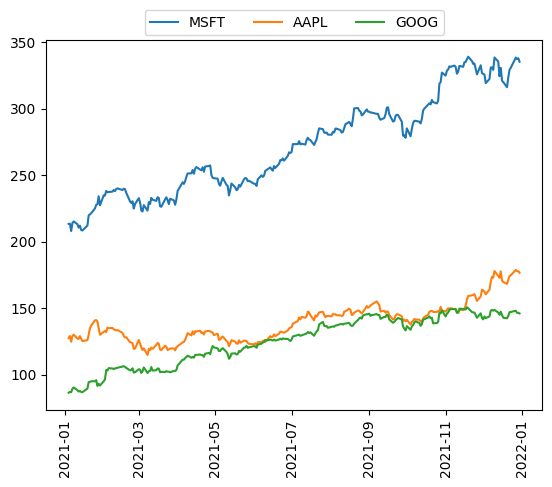

In [30]:
num_assets = 5
seed = 1234

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()
try:
    data = YahooDataProvider(
        tickers=["MSFT", "AAPL", "GOOG"],
        start=datetime.datetime(2021, 1, 1),
        end=datetime.datetime(2021, 12, 31),
    )
    data.run()
    for (cnt, s) in enumerate(data._tickers):
        plt.plot(data._data[cnt], label=s)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3)
    plt.xticks(rotation=90)
    plt.show()
except QiskitFinanceError as ex:
    data = None
    print(ex)


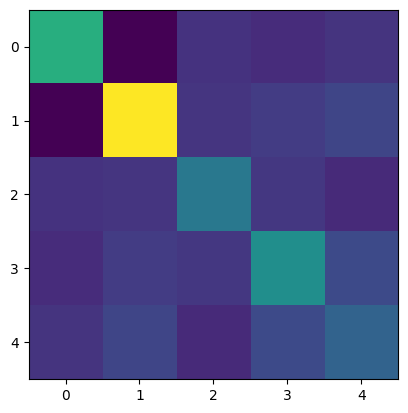

In [31]:
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [34]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.00031031611712545033*x_0^2 - 0.00016484212727705..., 5 variables, 1 constraints, 'Portfolio optimization'>

In [32]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

In [35]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [0. 0. 1. 1. 0.], value -0.0135

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 1 0]	-0.0135		1.0000


In [36]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
vqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)

Optimal: selection [0. 0. 1. 1. 0.], value -0.0135

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 0 0 0]	0.0019		0.3789
[1 0 0 1 0]	-0.0107		0.0762
[0 0 1 1 0]	-0.0135		0.0713
[1 0 1 1 0]	-0.0159		0.0645
[0 0 1 1 1]	-0.0129		0.0615
[1 1 0 0 1]	0.0025		0.0420
[0 1 0 0 1]	0.0051		0.0400
[0 0 1 0 1]	-0.0048		0.0361
[1 0 1 0 0]	-0.0077		0.0361
[0 1 0 0 0]	0.0045		0.0352
[0 0 0 1 1]	-0.0076		0.0322
[0 0 1 0 0]	-0.0053		0.0254
[0 0 0 1 0]	-0.0082		0.0205
[1 0 0 1 1]	-0.0101		0.0186
[1 0 0 0 1]	-0.0020		0.0137
[1 1 0 1 0]	-0.0063		0.0117
[0 1 1 0 0]	-0.0007		0.0098
[1 0 1 0 1]	-0.0072		0.0078
[0 0 0 0 0]	0.0000		0.0049
[1 1 1 0 1]	-0.0027		0.0039
[0 1 0 1 0]	-0.0036		0.0039
[1 0 0 0 0]	-0.0025		0.0029
[1 1 0 1 1]	-0.0055		0.0010
[1 1 1 0 0]	-0.0033		0.0010
[0 1 1 0 1]	-0.0002		0.0010


In [13]:
algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 1.], value -0.0149

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 1 0]	-0.0140		0.1719
 [0 0 1 1]	-0.0010		0.1641
 [1 1 0 0]	-0.0130		0.1641
 [1 0 0 1]	-0.0149		0.1631
 [0 1 0 1]	0.0002		0.1562
 [0 1 1 0]	0.0008		0.1523
 [1 1 1 1]	-0.0139		0.0059
 [1 1 1 0]	-0.0130		0.0049
 [0 0 0 0]	0.0000		0.0049
 [1 0 0 0]	-0.0140		0.0029
 [0 1 1 1]	-0.0000		0.0029
 [1 1 0 1]	-0.0139		0.0020
 [1 0 1 1]	-0.0150		0.0020
 [0 0 1 0]	-0.0001		0.0020
 [0 0 0 1]	-0.0008		0.0010
